Solo dibuja el rectangulo y la comparacion se realizaria con otra imagen previamnete rotada



1. Al hacer clic y mantener presionado el ratón, se inicia el dibujo del rectángulo.
Durante el movimiento del ratón, el código crea una copia temporal img_copy de img, dibuja el rectángulo sobre img_copy, y luego muestra img_copy en la ventana.
Esto da la ilusión de un rectángulo en tiempo real, pero img en sí no se modifica.
Finalización del Dibujo:

2. Al soltar el clic, drawing se establece en False, se capturan las coordenadas finales, y img se vuelve a mostrar sin el rectángulo temporal.
Inmediatamente después, crop_image() se llama para realizar el recorte.
Recorte de la Imagen:

3. crop_image() recorta directamente img en la región delimitada por las coordenadas (ix, iy) y (fx, fy).
Luego, muestra la imagen recortada en una nueva ventana "Imagen Recortada".

Total matches: 30


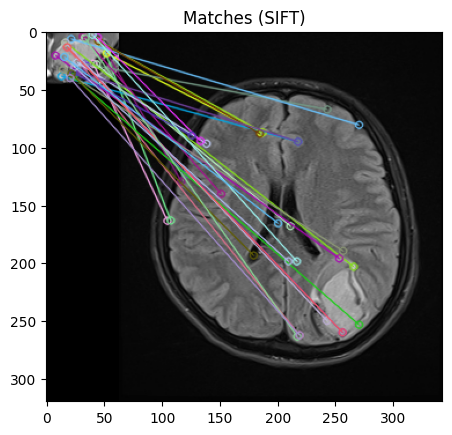

In [4]:
import cv2 as cv
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image
import matplotlib.pyplot as plt

# Variables globales
drawing = False  # Verdadero si el ratón está presionado
ix, iy = -1, -1  # Coordenadas iniciales del ratón
fx, fy = -1, -1  # Coordenadas finales del ratón
img = None  
img2 = None
cropped_image = None  # Imagen recortada para los matches

# Función de callback para el ratón
def draw_figures(event, x, y, flags, param):
    global ix, iy, fx, fy, drawing, img

    if event == cv.EVENT_LBUTTONDOWN:  # Al hacer clic, inicia el dibujo
        drawing = True
        ix, iy = x, y

    elif event == cv.EVENT_MOUSEMOVE:
        if drawing:
            # Dibuja un rectángulo en tiempo real sobre una copia temporal
            img_copy = img.copy()
            cv.rectangle(img_copy, (ix, iy), (x, y), (0, 0, 255), 1)
            cv.imshow('Imagen', img_copy)

    elif event == cv.EVENT_LBUTTONUP:  # Al soltar el clic, fija el dibujo
        drawing = False
        fx, fy = x, y
        crop_image()  # Llama a la función para recortar la imagen


def crop_image():
    global img, ix, iy, fx, fy, cropped_image
    x1, y1 = min(ix, fx), min(iy, fy)
    x2, y2 = max(ix, fx), max(iy, fy)
    cropped_image = img[y1:y2, x1:x2]  # Recorta la imagen original
    cv.imshow('Imagen Recortada', cropped_image) 


# Método para encontrar los matches con SIFT entre la imagen recortada y la imagen completa
def sift_matches():
    global cropped_image, img2
    if cropped_image is None or img2 is None:
        print("Debe seleccionar una región en la imagen primero.")
        return

    # Convertir la imagen recortada y la imagen completa a escala de grises
    img1_gray = cv.cvtColor(cropped_image, cv.COLOR_BGR2GRAY)
    img2_gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

    # Crear el objeto SIFT
    sift = cv.SIFT_create(
        nfeatures=nfeatures_scale.get(),
        nOctaveLayers=nOctaveLayers_scale.get(),
        contrastThreshold=contrastThreshold_scale.get(),
        edgeThreshold=edgeThreshold_scale.get(),
        sigma=sigma_scale.get()
    )

    # Detectar puntos clave y calcular descriptores
    keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2_gray, None)

    # Usar BFMatcher para encontrar los mejores matches
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)

    if len(matches) == 0:
        messagebox.showinfo("Error", "No se encontraron matches.")
        return

    # Ordenar los matches por distancia
    matches = sorted(matches, key=lambda x: x.distance)
    print(f"Total matches: {len(matches)}")

    # Dibujar los primeros 50 matches
    img_matches = cv.drawMatches(cropped_image, keypoints1, img2, keypoints2, matches[:50], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Mostrar la imagen con los matches
    cv.imshow('Matches (SIFT)', img_matches)
    cv.waitKey(0)
    cv.destroyAllWindows()

    # Mostrar usando matplotlib
    plt.imshow(cv.cvtColor(img_matches, cv.COLOR_BGR2RGB))
    plt.title('Matches (SIFT)')
    plt.show()

# Función para abrir la primera imagen y mostrarla en OpenCV
def open_file():
    global img
    # Abrir cuadro de diálogo para seleccionar archivo
    file_path = filedialog.askopenfilename(filetypes=[("PNG Files", "*.png"), ("JPG Files", "*.jpg")])
    if file_path:
        # Cargar la imagen con PIL y convertirla para OpenCV
        img = Image.open(file_path).convert("RGB")  
        img = np.array(img)  
        img = cv.cvtColor(img, cv.COLOR_RGB2BGR)  
        cv.imshow('Imagen', img)
        
        cv.setMouseCallback('Imagen', draw_figures)
        
        cv.waitKey(0)
        cv.destroyAllWindows()

# Función para abrir la segunda imagen
def open_second_file():
    global img2
    # Abrir cuadro de diálogo para seleccionar la segunda imagen
    file_path = filedialog.askopenfilename(filetypes=[("PNG Files", "*.png"), ("JPG Files", "*.jpg")])
    if file_path:
        # Cargar la segunda imagen con PIL y convertirla para OpenCV
        img2 = Image.open(file_path).convert("RGB")
        img2 = np.array(img2)
        img2 = cv.cvtColor(img2, cv.COLOR_RGB2BGR)

# Configuración de la ventana de Tkinter
window = tk.Tk()
window.title("Interfaz de Selección de Imagen")
window.geometry("500x500")

# Botón para seleccionar la imagen
open_button = tk.Button(window, text="Abrir imagen", command=open_file)
open_button.pack(pady=5)
open_button2 = tk.Button(window, text="Abrir segunda imagen", command=open_second_file)
open_button2.pack(pady=5)

# Trackbars para los parámetros de SIFT
nfeatures_scale = tk.Scale(window, from_=0, to=5000, orient=tk.HORIZONTAL, label="Número de características")
nfeatures_scale.pack(pady=8)
nOctaveLayers_scale = tk.Scale(window, from_=0, to=10, variable=tk.IntVar(value=8), orient=tk.HORIZONTAL, label="Número de capas por octava")
nOctaveLayers_scale.pack(pady=8)
contrastThreshold_scale = tk.Scale(window, from_=0, to=1, resolution=0.01, variable=tk.DoubleVar(value=0.04), orient=tk.HORIZONTAL, label="Umbral de contraste")
contrastThreshold_scale.pack(pady=8)
edgeThreshold_scale = tk.Scale(window, from_=0, to=10, variable=tk.IntVar(value=5), orient=tk.HORIZONTAL, label="Umbral de borde")
edgeThreshold_scale.pack(pady=8)
sigma_scale = tk.Scale(window, from_=0, to=100, resolution=0.1, variable=tk.DoubleVar(value=1.6), orient=tk.HORIZONTAL, label="Sigma")
sigma_scale.pack(pady=8)

# Botón para encontrar los matches con SIFT entre la imagen original y la región recortada
sift_button = tk.Button(window, text="Encontrar matches (SIFT)", command=sift_matches)
sift_button.pack(pady=5)

# Ejecuta la ventana de Tkinter
window.mainloop()


en este codigo se hace las transformaciones sobre la imagen y se selecciona un rectangulo sobre la misma para posteriormente hacer el matching

Total matches: 20


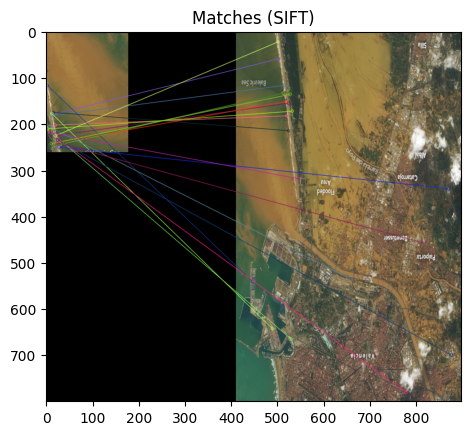

Total matches: 42


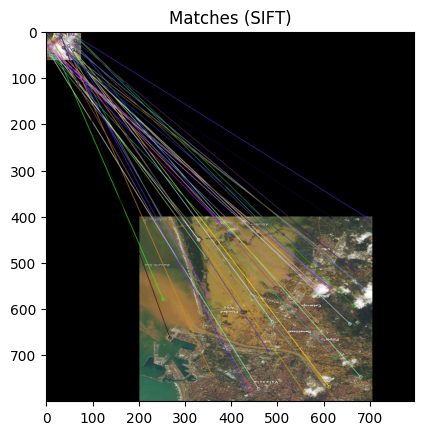

In [7]:
import cv2 as cv
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image
import matplotlib.pyplot as plt

# Variables globales
drawing = False
ix, iy = -1, -1
fx, fy = -1, -1
img = None
cropped_image = None
transformed_image = None
w, h = 0, 0

# Variables para transformaciones
tx, ty = 0, 0
angle = 0
scale_x = 1.0
scale_y = 1.0

# Función para aplicar transformaciones y mostrar imagen transformada
def apply_transformations():
    global transformed_image, tx, ty, angle, scale_x, scale_y, img, w, h
    
    # Verificar si la imagen está cargada
    if img is None:
        return  # No hacer nada si la imagen no está cargada

    # Centro de la imagen para la rotación
    center = (w / 2, h / 2)

    # Crear la matriz de transformación afín
    M = cv.getRotationMatrix2D(center, float(angle), 1.0)
    M[0, 0] *= scale_x
    M[0, 1] *= scale_x
    M[1, 0] *= scale_y
    M[1, 1] *= scale_y
    M[0, 2] += tx
    M[1, 2] += ty

    # Aplicar la transformación afín sobre la imagen original
    transformed_image = cv.warpAffine(img, M, (w, h), flags=cv.INTER_LINEAR, borderMode=cv.BORDER_CONSTANT, borderValue=(0, 0, 0))
    cv.imshow('Imagen Transformada', transformed_image)

# Función de callback para el ratón para seleccionar la región
def draw_figures(event, x, y, flags, param):
    global ix, iy, fx, fy, drawing, img

    if event == cv.EVENT_LBUTTONDOWN:
        drawing = True
        ix, iy = x, y

    elif event == cv.EVENT_MOUSEMOVE:
        if drawing:
            img_copy = img.copy()
            cv.rectangle(img_copy, (ix, iy), (x, y), (0, 0, 255), 1)
            cv.imshow('Imagen Original', img_copy)

    elif event == cv.EVENT_LBUTTONUP:
        drawing = False
        fx, fy = x, y
        crop_image()

# Función para recortar la región seleccionada
def crop_image():
    global img, ix, iy, fx, fy, cropped_image
    x1, y1 = min(ix, fx), min(iy, fy)
    x2, y2 = max(ix, fx), max(iy, fy)
    cropped_image = img[y1:y2, x1:x2]
    #cv.imshow('Imagen Recortada', cropped_image)

# Función para hacer el emparejamiento SIFT entre la región seleccionada y la imagen transformada
def sift_matches():
    global cropped_image, transformed_image
    if cropped_image is None or transformed_image is None:
        messagebox.showinfo("Error", "Primero selecciona una región y aplica una transformación.")
        return

    img1_gray = cv.cvtColor(cropped_image, cv.COLOR_BGR2GRAY)
    img2_gray = cv.cvtColor(transformed_image, cv.COLOR_BGR2GRAY)

    # Asegurarnos de que sigma y otros parámetros son válidos
    sigma_value = max(0.1, float(sigma_scale.get()))
    sift = cv.SIFT_create(
        nfeatures=int(nfeatures_scale.get()),
        nOctaveLayers=int(nOctaveLayers_scale.get()),
        contrastThreshold=float(contrastThreshold_scale.get()),
        edgeThreshold=int(edgeThreshold_scale.get()),
        sigma=sigma_value
    )

    keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2_gray, None)

    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)

    if len(matches) == 0:
        messagebox.showinfo("Error", "No se encontraron matches.")
        return

    matches = sorted(matches, key=lambda x: x.distance)
    print(f"Total matches: {len(matches)}")

    img_matches = cv.drawMatches(cropped_image, keypoints1, transformed_image, keypoints2, matches[:50], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    cv.imshow('Matches (SIFT)', img_matches)
    cv.waitKey(0)
    cv.destroyAllWindows()

    plt.imshow(cv.cvtColor(img_matches, cv.COLOR_BGR2RGB))
    plt.title('Matches (SIFT)')
    plt.show()

# Función para abrir la imagen
def open_file():
    global img, w, h
    file_path = filedialog.askopenfilename(filetypes=[("PNG Files", "*.png"), ("JPG Files", "*.jpg")])
    if file_path:
        img = Image.open(file_path).convert("RGB")  
        img = np.array(img)  
        img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
        
        # PREPROCESADO DE LA IMAGEN PARA MEJORAR LOS MATCHES???
        # Convertir a escala de grises para el procesamiento
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        # 1. Aumento de contraste con CLAHE
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_clahe = clahe.apply(img_gray)

        # 2. Suavizado Gaussiano para reducir el ruido
        img_smooth = cv.GaussianBlur(img_clahe, (5, 5), 1)
        
        # 3. Convertir de nuevo a BGR para mostrar
        img = cv.cvtColor(img_smooth, cv.COLOR_GRAY2BGR)
        
        h, w = img.shape[:2]
        cv.imshow('Imagen Original', img)
        cv.setMouseCallback('Imagen Original', draw_figures)

# Funciones para los sliders de transformación
def on_trackbar_rotation(val):
    global angle
    angle = float(val)
    if img is not None:  # Aplicar transformaciones solo si la imagen está cargada
        apply_transformations()

def on_trackbar_translation_x(val):
    global tx
    tx = float(val) - 100  # Permitir traslación negativa
    if img is not None:
        apply_transformations()

def on_trackbar_translation_y(val):
    global ty
    ty = float(val) - 100  # Permitir traslación negativa
    if img is not None:
        apply_transformations()

def on_trackbar_resize_x(val):
    global scale_x
    scale_x = float(val) / 100
    if img is not None:
        apply_transformations()

def on_trackbar_resize_y(val):
    global scale_y
    scale_y = float(val) / 100
    if img is not None:
        apply_transformations()

# Configuración de la ventana de Tkinter
window = tk.Tk()
window.title("Transformaciones y SIFT")
window.geometry("720x700")

# Trackbars para las transformaciones (primera fila)

transform_label = tk.Label(window, text="Transformaciones", font=("Arial", 12, "bold"))
transform_label.place(x=20, y=20)

rotation_scale = tk.Scale(window, from_=0, to=360, orient=tk.HORIZONTAL, label="Rotación (grados)", command=on_trackbar_rotation)
rotation_scale.place(x=200, y=50, width=300)

translation_x_scale = tk.Scale(window, from_=0, to=200, orient=tk.HORIZONTAL, label="Traslación X", command=on_trackbar_translation_x)
translation_x_scale.place(x=400, y=120, width=300)

translation_y_scale = tk.Scale(window, from_=0, to=200, orient=tk.HORIZONTAL, label="Traslación Y", command=on_trackbar_translation_y)
translation_y_scale.place(x=400, y=190, width=300)

resize_x_scale = tk.Scale(window, from_=50, to=150, orient=tk.HORIZONTAL, label="Escala X (%)", command=on_trackbar_resize_x)
resize_x_scale.set(100)
resize_x_scale.place(x=20, y=120, width=300)

resize_y_scale = tk.Scale(window, from_=50, to=150, orient=tk.HORIZONTAL, label="Escala Y (%)", command=on_trackbar_resize_y)
resize_y_scale.set(100)
resize_y_scale.place(x=20, y=190, width=300)



# Trackbars para los parámetros de SIFT (segunda fila)

sift_label = tk.Label(window, text="Parámetros de SIFT", font=("Arial", 12, "bold"))
sift_label.place(x=20, y=320)

nfeatures_scale = tk.Scale(window, from_=0, to=5000, orient=tk.HORIZONTAL, label="Número de características")
nfeatures_scale.set(0)  # Valor inicial
nfeatures_scale.place(x=20, y=360, width=300)

nOctaveLayers_scale = tk.Scale(window, from_=0, to=10, orient=tk.HORIZONTAL, label="Número de capas por octava")
nOctaveLayers_scale.set(3)
nOctaveLayers_scale.place(x=400, y=360, width=300)

contrastThreshold_scale = tk.Scale(window, from_=0, to=1, resolution=0.01, orient=tk.HORIZONTAL, label="Umbral de contraste")
contrastThreshold_scale.set(0.04)
contrastThreshold_scale.place(x=20, y=430, width=300)

edgeThreshold_scale = tk.Scale(window, from_=0, to=10, orient=tk.HORIZONTAL, label="Umbral de borde")
edgeThreshold_scale.set(5)
edgeThreshold_scale.place(x=400, y=430, width=300)

sigma_scale = tk.Scale(window, from_=0, to=10, resolution=0.1, orient=tk.HORIZONTAL, label="Sigma")
sigma_scale.set(1.6)
sigma_scale.place(x=200, y=500, width=300)

# Botones para abrir la imagen y realizar matching (debajo de las filas de trackbars)
open_button = tk.Button(window, text="Abrir imagen", command=open_file)
open_button.place(x=200, y=600, width=120, height=30)

sift_button = tk.Button(window, text="Encontrar matches (SIFT)", command=sift_matches)
sift_button.place(x=350, y=600, width=150, height=30)

# Ejecuta la ventana de Tkinter
window.mainloop()
